In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import itertools, random, copy

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


<h4><font color="red">Choose replicate to analyze below</font></h4>

In [2]:
# should be "pooled", "1", "2" (strings)
REPLICATE = "pooled"
ENRICHMENT_FILE = f"../fig_2cd-s3-s4-s5/hA5-hA6-aA5A6-alt_enrichment_{REPLICATE}.txt"

## Fig 4A

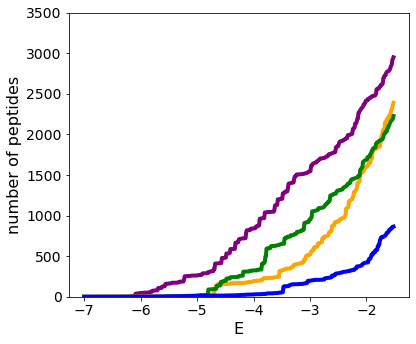

In [3]:
df = pd.read_csv(ENRICHMENT_FILE)

E = np.arange(-7,-1.51,0.01)
hA5 = []
hA6 = []
aA5A6 = []
alt = []
for c in E:
    hA5.append(np.sum(df["hA5"]<=c))
    hA6.append(np.sum(df["hA6"]<=c))
    aA5A6.append(np.sum(df["aA5A6"]<=c))
    alt.append(np.sum(df["alt"]<=c))

fig, ax = plt.subplots(1,figsize=(6,5))
    
ax.plot(E,hA5,color="purple",lw=4,label="hA5")
ax.plot(E,hA6,color="orange",lw=4,label="hA6")
ax.plot(E,aA5A6,color="green",lw=4,label="aA5A6")
ax.plot(E,alt,color="blue",lw=4,label="alt")

ax.set_ylim(0,3500)
ax.set_xlabel("E")
ax.set_ylabel("number of peptides")

fig.tight_layout()

fig.savefig("fig_4a.pdf")


## Fig 4B

In [4]:
import venninator
from matplotlib_venn import venn3, venn2

def create_plot(regions,counts,out_file=None):
    """
    Create a venn diagram plot.
    """

    # Create dictionary of fake sequences for each protein.  Sequences share 
    # appropriate overlaps from the venn regions, so when we send to venn3, it
    # creates an appropriate plot
    prot_dict = {}
    for i, v in enumerate(regions):
        if v == tuple([]):
            continue

        # This set will have completely random integers from 0 to 1e10.  
        this_set = [int(round(random.random()*1e10,0))
                    for i in range(int(round(counts[i],0)))]

        # Now go through proteins in this venn region and add the set of integers
        # from above to that protein.
        for prot in v:
            try:
                prot_dict[prot].extend(this_set)
            except KeyError:
                prot_dict[prot] = copy.copy(this_set)

    # Create list of unique proteins
    prots = list(prot_dict.keys())
    prots.sort()

    # Turn random integers into sets
    integer_sets = []
    for p in prots:
        integer_sets.append(set(prot_dict[p]))
       
    # Create a pretty figure 
    venn3(integer_sets,prots)
    
    if out_file is not None:
        plt.savefig(out_file)
        
    plt.show()
    plt.close()


def calc_venn(enrichment_file,E_value,prot_list=None,plot=False):
    """
    Calculate the overlap between sets given a cutoff for each enrichment and
    the predicted enrichment of each peptide.
    """

    predictions = pd.read_csv(enrichment_file)
    if prot_list is None:
        prot_list = list(predictions.columns[2:])
    
    # This is a hack.  Venninator wants a false negative and false positive rate for
    # each call.  We are ignoring this feature, but it needs values anyway. 
    fpr = {}
    fnr = {}
    for p in prot_list:
        fpr[p] = 0.00001
        fnr[p] = 0.00001
    
    prot_set = {}
    for p in prot_list:
        prot_set[p] = set(predictions.seq[predictions[p] < E_value])

    combos = ["-"]
    count_dict = {}
    for i in range(1,len(prot_list)+1):
        for combo in itertools.combinations(prot_list,i):
            combos.append(combo)

            # Sequences in the particular combo        
            prot_in_combo = set(combo)
            seq_in_combo = set.intersection(*[prot_set[p] for p in prot_in_combo])

            # All sequences not in this particular combination
            prot_out_combo = set(prot_list) - prot_in_combo
            if len(prot_out_combo) > 0:
                seq_out_of_combo = set.union(*[prot_set[p] for p in prot_out_combo])
            else:
                seq_out_of_combo = set([])
   
            # Get the sequences in the combo that do not overlap with any sequence
            # not in the combo
            count_dict[combo] = len(seq_in_combo - seq_out_of_combo)
             
    count_dict["-"] = len(predictions.seq) - sum(count_dict.values())

    s = venninator.SetEstimator(fp=fpr,fn=fnr,count_dict=count_dict)
    
    final_dict = {}
    for i, v in enumerate(s.venn_regions):
    
        if v == tuple([]):
            name = "---"
        else:
            name = "-".join(v) 
            
        final_dict[name] = int(s._count_dict[v])


    if plot:
        obs = np.array([s._count_dict[v] for v in s.venn_regions])
        
        out_file_name = "{}_{:.2f}.pdf".format("-".join(prot_list),E_value)
        create_plot(s.venn_regions,obs,out_file=out_file_name)

    return final_dict
    
    
def loop_over_E(enrichment_file,E_values,prot_list=None,plot_every=5):
    
    out_dict = None
    for i, E_value in enumerate(E_values): 

        plot = False
        if i % plot_every == 0:
            plot = True
            print(E_value)

        results = calc_venn(enrichment_file,
                            E_value=E_value,
                            prot_list=prot_list,
                            plot=plot)

        if out_dict is None:
            out_dict = {"E":[E_value]}
            for r in results:
                out_dict[r] = [results[r]]
        else:
            out_dict["E"].append(E_value)
            for r in results:
                out_dict[r].append(results[r])

    return pd.DataFrame(out_dict)
    
    

### ancA5/A6 Venn diagrams

-7.0


/Users/harmsm/miniconda3/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:47: UserWarning: All circles have zero area
  warnings.warn("All circles have zero area")


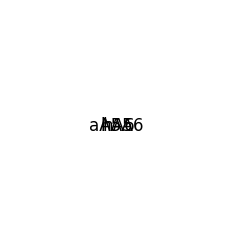

-6.500000000000002


/Users/harmsm/miniconda3/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")
/Users/harmsm/miniconda3/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


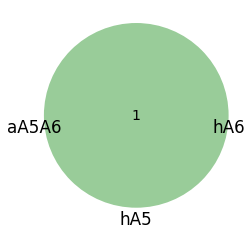

-6.0000000000000036


/Users/harmsm/miniconda3/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")


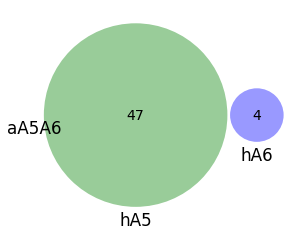

-5.500000000000005


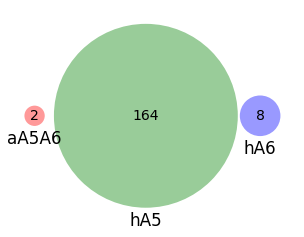

-5.000000000000007


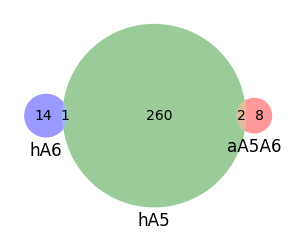

-4.500000000000009


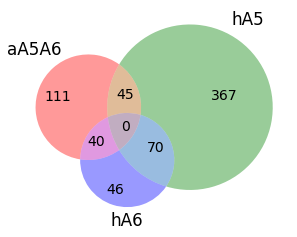

-4.000000000000011


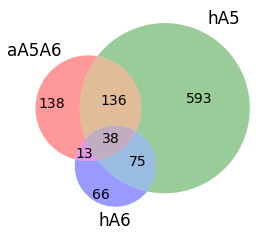

-3.5000000000000124


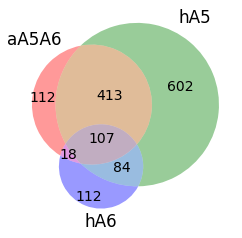

-3.000000000000014


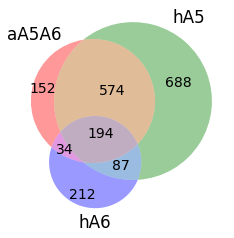

-2.500000000000016


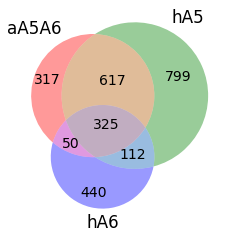

-2.0000000000000178


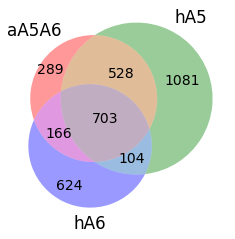

-1.5000000000000195


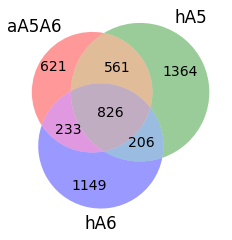

In [5]:
E_values = np.arange(-7,-1.4,0.1)

aA5A6_overlaps = loop_over_E(ENRICHMENT_FILE,E_values,prot_list=["hA5","hA6","aA5A6"],plot_every=5)

### alt Venn diagrams

-7.0


/Users/harmsm/miniconda3/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:47: UserWarning: All circles have zero area
  warnings.warn("All circles have zero area")


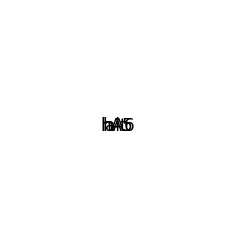

-6.500000000000002


/Users/harmsm/miniconda3/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")
/Users/harmsm/miniconda3/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


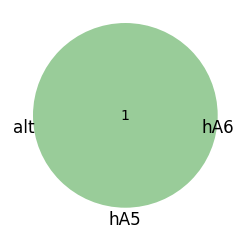

-6.0000000000000036


/Users/harmsm/miniconda3/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")


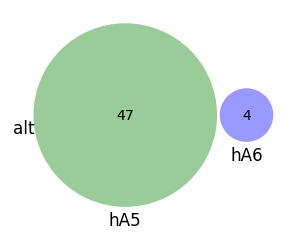

-5.500000000000005


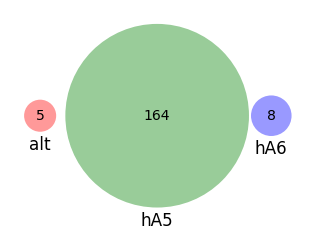

-5.000000000000007


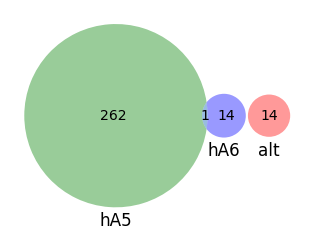

-4.500000000000009


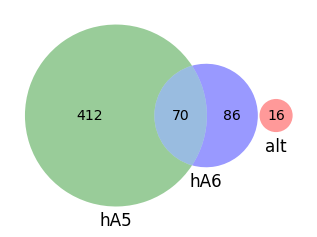

-4.000000000000011


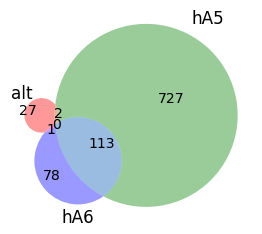

-3.5000000000000124


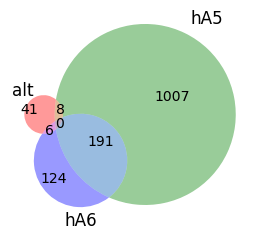

-3.000000000000014


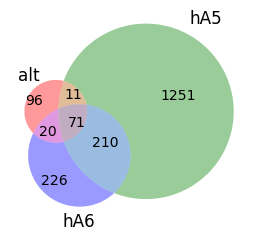

-2.500000000000016


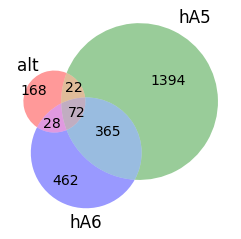

-2.0000000000000178


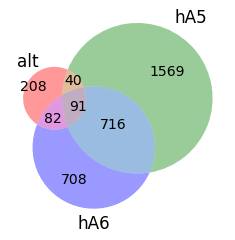

-1.5000000000000195


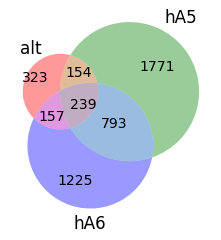

In [6]:
alt_overlaps = loop_over_E(ENRICHMENT_FILE,E_values,prot_list=["hA5","hA6","alt"],plot_every=5)

## Fig 4C,D

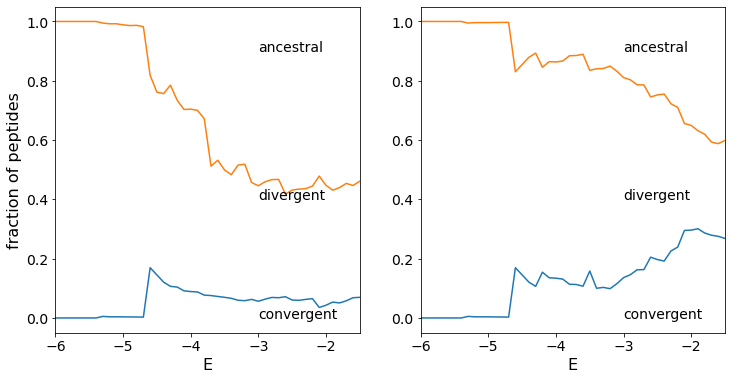

In [7]:

fig, ax = plt.subplots(1,2,figsize=(12,6))

df = aA5A6_overlaps
ax[0].plot(df["E"],(df["hA5-hA6"])/(df["hA5"] + df["hA5-hA6"] + df["aA5A6-hA5"] + df["aA5A6-hA5-hA6"]))
ax[0].plot(df["E"],(df["hA5"])/(df["hA5"] + df["hA5-hA6"] + df["aA5A6-hA5"] + df["aA5A6-hA5-hA6"]))

df = alt_overlaps
ax[1].plot(df["E"],(df["hA5-hA6"])/(df["hA5"] + df["hA5-hA6"] + df["alt-hA5"] + df["alt-hA5-hA6"]))
ax[1].plot(df["E"],(df["hA5"])/(df["hA5"] + df["hA5-hA6"] + df["alt-hA5"] + df["alt-hA5-hA6"]))


ax[0].set_ylabel("fraction of peptides")
for i in range(2):
    ax[i].text(-3,0.9,"ancestral")
    ax[i].text(-3,0.4,"divergent")
    ax[i].text(-3,0.0,"convergent")
    
    ax[i].set_xlim(-6,-1.5)
    ax[i].set_xlabel("E")
    
fig.savefig("fig_4cd_rep1.pdf")
    

## Fig 5

/Users/harmsm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
/Users/harmsm/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/harmsm/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/harmsm/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


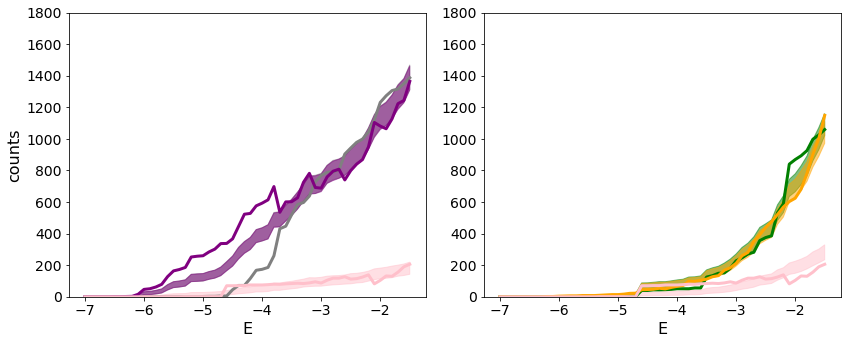

In [8]:



def resample_E(protein,df,assumed_correct_below=-4,num_samples=1000):


    divergent = df[f"{protein}"]
    convergent = df["hA5-hA6"]
    ancestral = df[f"aA5A6-{protein}"] + df["aA5A6-hA5-hA6"]

    regions = {"divergent":np.sum(divergent[df.E >= assumed_correct_below]),
               "convergent":np.sum(convergent[df.E >= assumed_correct_below]),
               "ancestral":np.sum(ancestral[df.E >= assumed_correct_below])}

    region_names = np.arange(len(regions.keys()),dtype=np.int) 
    fx_vector = np.array([regions[r] for r in regions.keys()])
    fx_vector = fx_vector/np.sum(fx_vector)

    total_peptides_vs_E = divergent + convergent + ancestral


    out_dict = {"E":[],
                "obs":[],
                "mu":[],
                "sigma":[],
                "ninetyfive":[],
                "p":[],
                "region":[]}

    for i, num_pep in enumerate(total_peptides_vs_E):

        # What did we see in each region 
        what_was_seen = np.array((divergent[i],convergent[i],ancestral[i]))

        out = np.zeros((num_samples,len(region_names)),dtype=int)
        for j in range(num_samples):

            # Draw randomly, with replacement, from the region names with fx_vector
            # probabilities num_pep times.
            s = np.bincount(np.random.choice(region_names,
                                             size=num_pep,
                                             replace=True,
                                             p=fx_vector))
            out[j,:len(s)] = s

        # Mean and standard deviations of draw distributions
        mu = np.mean(out,axis=0)
        sigma = np.std(out,axis=0)

        # Calculate proability of seeing what_was_seen 
        Z = (what_was_seen - mu)/sigma
        p = stats.norm.sf(abs(Z))

        for j, r in enumerate(regions.keys()):
            out_dict["E"].append(df.E.iloc[i])
            out_dict["obs"].append(what_was_seen[j])
            out_dict["mu"].append(mu[j])
            out_dict["sigma"].append(sigma[j])
            out_dict["ninetyfive"].append(sigma[j]*2.92)
            out_dict["p"].append(p[j])
            out_dict["region"].append(r)

    out_df = pd.DataFrame(out_dict)

    return out_df


hA5_sampled = resample_E("hA5",aA5A6_overlaps)
hA6_sampled = resample_E("hA6",aA5A6_overlaps)


fig, ax = plt.subplots(1,2,figsize=(12,5))

def add_series(df,region,color,ax):
    
    a = df[df.region == region]

    ax.plot(a.E,a.obs,color=color,linewidth=3)
    x = np.concatenate((a.E,a.E[::-1]))
    y = np.concatenate((a.mu + a.ninetyfive,(a.mu - a.ninetyfive)[::-1]))
    ax.fill(x,y,color=color,alpha=0.5)


add_series(hA5_sampled,"ancestral","gray",ax[0])
add_series(hA5_sampled,"divergent","purple",ax[0])
add_series(hA5_sampled,"convergent","pink",ax[0])

add_series(hA6_sampled,"ancestral","green",ax[1])
add_series(hA6_sampled,"divergent","orange",ax[1])
add_series(hA6_sampled,"convergent","pink",ax[1])

ax[0].set_ylabel("counts")
for i in range(2):
    ax[i].set_ylim(0,1800)
    ax[i].set_xlabel("E")

fig.tight_layout()
fig.savefig("fig_5.pdf")

## Determine if "missing" peptides with -1.5 < E < 0 had alter specificity inference

In [9]:

def calc_simmed_responsive(mu,std,num_seen_real,cutoff=-1.5):

    # Build distribution
    n = stats.norm(mu,std)
    total_area = np.sum(n.cdf(np.arange(-10,10,0.1)))
    
    # Calculate -inf -> 0
    full = np.sum(n.cdf(np.arange(-10,0,0.1)))/total_area
    
    # Calculate -inf -> cutoff
    obs = np.sum(n.cdf(np.arange(-10,cutoff,0.1)))/total_area
    
    # Multiply ratio of areas by the number observed to scale up
    return full/obs*num_seen_real

# Read files
enrichments = pd.read_csv(ENRICHMENT_FILE)
gaussian_stats_df = pd.read_csv("../fig_2cd-s3-s4-s5/enrichment-distribution-stats.csv")

for name in ["hA5","hA6","aA5A6","alt"]:

    sample = f"{name}_{REPLICATE}"
    
    # Get counts for E <= -1.5 for this protein
    counts_at_cutoff = np.sum(enrichments.loc[:,name] <= -1.5)
    
    # Get mean and standard deviation of the responsive distribution
    r_mean = gaussian_stats_df.r_mean.loc[gaussian_stats_df.experiment == sample].iloc[0]
    r_std = gaussian_stats_df.r_std.loc[gaussian_stats_df.experiment == sample].iloc[0]

    print(name,r_mean,r_std,counts_at_cutoff,calc_simmed_responsive(r_mean,r_std,counts_at_cutoff))

hA5 -0.9798173599564044 2.8631921495307293 2957 5604.725476196572
hA6 -0.11438029800256427 2.0100887103795366 2414 7186.538005502677
aA5A6 -0.4640670264463181 2.3991943074974955 2241 5172.57651332241
alt 0.0027375316017501047 1.7395718281007928 873 3293.4575291825413
